In [1]:
import pdb
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from faker import Faker
import prince
np.random.seed(3101)
random_state = np.random.RandomState(3101)
fake = Faker()
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))

# Importing data:
bank1 = archive  
bank2 = bank+marketing

In [2]:
# print(os.getcwd())
bank_df_train = pd.read_csv('./data/main/train.csv')
bank_df_test = pd.read_csv('./data/main/test.csv')

In [3]:
print(bank_df_train.head())
print(len(bank_df_train))

# bank_df_train_clean = bank_df_train.drop_duplicates(subset="CustomerId", keep="first")
# print(len(bank_df_train_clean))

   id  CustomerId         Surname  CreditScore Geography Gender       Age  \
0   0    15674932  Okwudilichukwu          668    France   Male 33.000000   
1   1    15749177   Okwudiliolisa          627    France   Male 33.000000   
2   2    15694510           Hsueh          678    France   Male 40.000000   
3   3    15741417             Kao          581    France   Male 34.000000   
4   4    15766172       Chiemenam          716     Spain   Male 33.000000   

   Tenure       Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       3      0.000000              2   1.000000        0.000000   
1       1      0.000000              2   1.000000        1.000000   
2      10      0.000000              2   1.000000        0.000000   
3       2 148882.540000              1   1.000000        1.000000   
4       5      0.000000              2   1.000000        1.000000   

   EstimatedSalary  Exited  
0    181449.970000       0  
1     49503.500000       0  
2    184866.690000       0  
3     

In [4]:
print(bank_df_test.head())
len(bank_df_test)
# duplicates = bank_df_test.duplicated(subset=['CustomerId'], keep=False)
# print(duplicates)
#no "exited" column

       id  CustomerId    Surname  CreditScore Geography  Gender       Age  \
0  165034    15773898   Lucchese          586    France  Female 23.000000   
1  165035    15782418       Nott          683    France  Female 46.000000   
2  165036    15807120         K?          656    France  Female 34.000000   
3  165037    15808905  O'Donnell          681    France    Male 36.000000   
4  165038    15607314    Higgins          752   Germany    Male 38.000000   

   Tenure       Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2      0.000000              2   0.000000        1.000000   
1       2      0.000000              1   1.000000        0.000000   
2       7      0.000000              2   1.000000        0.000000   
3       8      0.000000              1   1.000000        0.000000   
4      10 121263.620000              1   1.000000        0.000000   

   EstimatedSalary  
0    160976.750000  
1     72549.270000  
2    138882.090000  
3    113931.570000  
4    139431.00000

110023

Data Cleaning

Removed CustomerId column in both test & train since it is an unused var in the original dataset
All other columns returns no duplicates

In [5]:
# bank_df_train = bank_df_train.loc[:, bank_df_train.columns!='CustomerId'] # extract all columns except for CustomerId
# print(bank_df_train[bank_df_train.duplicated() == True]) # check for duplicate columns 

# bank_df_test = bank_df_test.loc[:, bank_df_test.columns!='CustomerId']

### DELETE OR COMMENT OUT THIS LATER ###
# bank_df_train.drop_duplicates(subset=['CustomerId'], inplace=True)
# bank_df_test.drop_duplicates(subset=['CustomerId'], inplace=True)
### DELETE OR COMMENT OUT THIS LATER ###

n_train = len(bank_df_train)
n_test = len(bank_df_test)

# Adding and populating features

### 13. Churn Date: The exact date the customer decided to exit.

In [6]:
start_date = "2023-01-01"
end_date = end_date = datetime.now().strftime('%Y-%m-%d') 

# random_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# random_dates_str = random_dates.strftime('%Y-%m-%d')
# bank_df_train['ChurnDate'] = np.where(bank_df_train['Exited'] == 1, np.random.choice(random_dates_str) , np.nan) 
def generate_random_date(exited):
    if exited == 1:
        random_date = np.random.choice(pd.date_range(start=start_date, end=end_date, freq='D'))
        return random_date
    else:
        return ''

bank_df_train['ChurnDate'] = bank_df_train['Exited'].apply(generate_random_date)
bank_df_train['ChurnDate'] = pd.to_datetime(bank_df_train['ChurnDate'])
print(bank_df_train['ChurnDate'].head(10))
# print(bank_df_train['ChurnDate'].unique())

0          NaT
1          NaT
2          NaT
3          NaT
4          NaT
5   2023-07-20
6          NaT
7          NaT
8          NaT
9          NaT
Name: ChurnDate, dtype: datetime64[ns]


### 14. Sign Up Date: When did the customer create an account
has to be linked with churn date if any, and tenure. Tenure is usually rounded down, so (not needed anymore)


In [7]:
# def generate_signon_date(churn_date, tenure, exited):
#     if exited == 0:
#         churn_date = datetime.now().strftime('%Y-%m-%d')
#     churn_date = pd.to_datetime(churn_date)
#     max = churn_date - pd.DateOffset(years=tenure)
#     min = churn_date - pd.DateOffset(years=(tenure + 1))
#     random_dates = pd.date_range(min, max, freq='D').strftime('%Y-%m-%d')
#     random_date = np.random.choice(random_dates)
#     return random_date


# bank_df_train['SignDate'] = bank_df_train.apply(lambda row: generate_signon_date(row['ChurnDate'], row['Tenure'], row['Exited']), axis = 1)
# print(bank_df_train[['SignDate', 'ChurnDate', 'Tenure']].head(10))

# bank_df_test['SignDate'] = bank_df_train.apply(lambda row: generate_signon_date("2023-12-31", row['Tenure'], 0), axis = 1)
# # print(bank_df_train_clean.head(10))
# bank_df_train['SignDate'] = pd.to_datetime(bank_df_train['SignDate'])

### 15.Transaction History Freq
Detailed transaction data offers insights into spending patterns and engagement. (Transaction frequency in the last 28 days)

In [8]:
transaction_df = pd.read_excel('./data/transaction_history.xlsx')

# print(transaction_df.head())
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'])

grouped_df = transaction_df.groupby('Account No')

results = []
for group_name, group_data in grouped_df:
    # Get max and min dates for the group
    max_date = group_data['DATE'].max()
    min_date = max_date - pd.Timedelta(days=28)
    
    # Filter group data for transactions within the date range
    filtered_group = group_data[(group_data['DATE'] >= min_date) & (group_data['DATE'] <= max_date)]
    
    # Calculate transaction frequency and amount for the group
    transaction_frequency = len(filtered_group)
    transaction_amount = filtered_group['DEPOSIT AMT'].sum()
    
    # Append results to the list
    results.append({
        'Account No': group_name,
        'Total Transaction Amount': transaction_amount,
        'Transaction Frequency': transaction_frequency
    })

# Create DataFrame from results
result_df = pd.DataFrame(results)

result_df['Total Transaction Amount'] = result_df['Total Transaction Amount'].astype(int)
pd.options.display.float_format = '{:,.0f}'.format
# print(result_df['Total Transaction Amount'])

# print("Minimum date in the dataset:", min_date)
# print("Maximum date in the dataset:", max_date)

kde_freq = gaussian_kde(result_df['Transaction Frequency'])
kde_amnt = gaussian_kde(result_df['Total Transaction Amount'])
# print(result_df['Total Transaction Amount'])

fake_data_freq = kde_freq.resample(len(bank_df_train)).flatten()
fake_data_freq = np.round(fake_data_freq).astype(int)
bank_df_train['TransactionFreq'] = fake_data_freq
fake_data_freq = kde_freq.resample(len(bank_df_test)).flatten()
fake_data_freq = np.round(fake_data_freq).astype(int)
bank_df_test['TransactionFreq'] = fake_data_freq

# fake_data_amt = kde_amnt.resample(len(bank_df_train)).flatten()
# # fake_data_amt = np.round(fake_data_amt).astype(int)
# bank_df_train['TransactionAmnt'] = fake_data_amt
# fake_data_amt = kde_amnt.resample(len(bank_df_test)).flatten()
# # fake_data_amt = np.round(fake_data_amt).astype(int)
# bank_df_test['TransactionAmnt'] = fake_data_amt

# print(bank_df_train['TransactionAmnt'].head())
date_28_days_ago = datetime.now() - timedelta(days=28)

bank_df_train['TransactionFreq'] = np.where(
    (bank_df_train['ChurnDate'] <= date_28_days_ago),
    0,
    bank_df_train['TransactionFreq']
)

bank_df_test['TransactionFreq'] = np.where(
    (bank_df_test['IsActiveMember'] == 0),
    0,
    bank_df_test['TransactionFreq']
)

bank_df_train['TransactionFreq'] = np.maximum(bank_df_train['TransactionFreq'], 0)
bank_df_test['TransactionFreq'] = np.maximum(bank_df_test['TransactionFreq'], 0)

print(bank_df_train[['ChurnDate', 'TransactionFreq']].head(20))

    ChurnDate  TransactionFreq
0         NaT               16
1         NaT             1129
2         NaT              713
3         NaT                0
4         NaT              186
5  2023-07-20                0
6         NaT                0
7         NaT              420
8         NaT                0
9         NaT                0
10        NaT                0
11        NaT              196
12        NaT                0
13        NaT              733
14        NaT                3
15        NaT                0
16        NaT              427
17        NaT              456
18 2023-03-10                0
19 2023-12-18                0


### 16. Transaction History Amt
Detailed transaction data offers insights into spending patterns and engagement. (Transaction amount in the last 28 days)


In [9]:
# Import reference set
# Warning: File size slightly big
trans_hist_data = pd.read_excel('./data/transaction_history.xlsx')

trans_hist_data.dtypes
# trans_hist_data.describe()

# Extract the most recent 2 sets of 3 months assuming the most recent data is the most accurate
trans_1st_3mths = trans_hist_data[(trans_hist_data['DATE'] >= pd.to_datetime('2019-01')) & (trans_hist_data['DATE'] <= pd.to_datetime('2019-03'))]
trans_2ns_3mths = trans_hist_data[(trans_hist_data['DATE'] >= pd.to_datetime('2018-10')) & (trans_hist_data['DATE'] <= pd.to_datetime('2018-12'))]

trans_dist_data = trans_1st_3mths.groupby('Account No').agg({'VALUE DATE': 'size', 'WITHDRAWAL AMT':'sum', 'DEPOSIT AMT': 'sum'}).reset_index()
trans_dist_data['TOTAL AMT'] = -trans_dist_data['WITHDRAWAL AMT'] + trans_dist_data['DEPOSIT AMT']

# kde = gaussian_kde(trans_dist_data['VALUE DATE'])
# train['Transaction Freq'] = abs(kde.resample(n_train).flatten()).astype(int)

kde = gaussian_kde(trans_dist_data['TOTAL AMT'])
bank_df_train['TransactionAmt'] = kde.resample(n_train).flatten().astype(float)
bank_df_test['TransactionAmt'] = kde.resample(n_test).flatten().astype(float)

date_28_days_ago = datetime.now() - timedelta(days=28)

bank_df_train['TransactionAmt'] = np.where(
    (bank_df_train['ChurnDate'] <= date_28_days_ago),
    0,
    bank_df_train['TransactionAmt']
)

bank_df_train['TransactionAmt'] = np.where(
    (bank_df_train['TransactionFreq'] == 0),
    0,
    bank_df_train['TransactionAmt']
)

bank_df_test['TransactionAmt'] = np.where(
    (bank_df_test['TransactionFreq'] == 0),
    0,
    bank_df_test['TransactionAmt']
)

# bank_df_train['Transaction Amt'] = np.maximum(bank_df_train['Transaction Amt'], 0)

# print(bank_df_train[['ChurnDate', 'TransactionFreq', 'TransactionAmt']].head(20))
print(bank_df_test[['TransactionFreq', 'TransactionAmt']].head(20))

    TransactionFreq  TransactionAmt
0               459        -999,523
1                 0               0
2                 0               0
3                 0               0
4                 0               0
5                 0               0
6               527       1,220,319
7                 0               0
8                 0               0
9                69      -1,623,954
10              388      -3,906,738
11                0               0
12              348        -774,274
13                0               0
14                0               0
15               44       4,295,787
16              879       3,756,194
17                0               0
18                0               0
19                0               0


In [10]:
#bank_df_train[bank_df_train['TransactionAmt'] > bank_df_train['Balance']]

### 17.Service Support Frequency (per mth)

In [11]:

support_freq = pd.read_csv("./data/support_frequency.csv")
kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['ServiceSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)
bank_df_test['ServiceSupportFrequency'] = abs(kde.resample(n_test).flatten()/12).astype(int)

print(bank_df_train['ServiceSupportFrequency'])


0         12
1         32
2         11
3          0
4          9
          ..
165029     3
165030     3
165031     3
165032     0
165033     4
Name: ServiceSupportFrequency, Length: 165034, dtype: int32


### 18.Months Inactive
Indicates customer disengagement, potentially preceding churn. 

In [12]:
np.random.seed(3101)
# bank_df_train['MonthsInactive'] = np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12)
# bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)
# bank_df_train['MonthsInactive'] = bank_df_train['TransactionFreq'].apply(lambda x: 0 if x > 0 else  \
#                                                                               np.maximum(np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12), 0))
bank_df_train['MonthsInactive'] = bank_df_train.apply(lambda row: 
    np.random.normal(0.5, 1.5) if row['TransactionFreq'] == 0 else 0,
    axis=1)

bank_df_test['MonthsInactive'] = bank_df_test.apply(lambda row: 
    np.random.normal(0.5, 1.5) if row['TransactionFreq'] == 0 else 0,
    axis=1)

bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)
bank_df_test['MonthsInactive'] = np.maximum(bank_df_test['MonthsInactive'], 0)

# print(bank_df_train['MonthsInactive'].head(20))
print(bank_df_test['MonthsInactive'].head(20))

0    0
1    0
2    1
3    0
4    1
5    1
6    0
7    0
8    1
9    0
10   0
11   2
12   0
13   0
14   2
15   0
16   0
17   0
18   1
19   1
Name: MonthsInactive, dtype: float64


### 19.Net Promoter Score (NPS)
Measure of customer satisfaction and loyalty.
Scaled from 1 to 10 


In [13]:
nps = pd.read_csv('./data/NPS.csv')

nps_data = nps.groupby('Customer Name').agg({'NPS':'mean'}).reset_index()
kde = gaussian_kde(nps_data['NPS'])
bank_df_train['NPS'] = abs(kde.resample(n_train).flatten()).astype(int)
bank_df_test['NPS'] = abs(kde.resample(n_test).flatten()).astype(int)
bank_df_train['NPS'] = np.ceil(bank_df_train['NPS']/12*10)
bank_df_test['NPS'] = np.ceil(bank_df_test['NPS']/12*10)
print(bank_df_train['NPS'].describe())

count   165,034
mean          6
std           3
min           0
25%           4
50%           7
75%           8
max          10
Name: NPS, dtype: float64


### 20.Education
Education level might influence financial behavior and churn.
Shld be correlated to 5. Acct Balance


In [14]:
education_marital = pd.read_csv("./data/education_marital.csv")

education = education_marital['Education_Level'].unique()

edu, counts = np.unique(education, return_counts=True)
value_to_index = {value: i for i, value in enumerate(edu)}
numerical_data = [value_to_index[value] for value in education]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [edu[index] for index in resampled_indices]
resampled_values_test = [edu[index] for index in resampled_indices_test]

bank_df_train['Education'] = resampled_values
bank_df_test['Education'] = resampled_values_test

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  IsActiveMember  EstimatedSalary  Exited  \
0        0              2  ...               0          181,450       0   
1        0              2  ...               1           49,504       0   
2        0              2  ...               0          184,867       0   
3  148,883              1  ...               1           84,561       0   
4        0              2  ...               1           15,069       0   

   ChurnDate TransactionFreq  TransactionAmt  ServiceSupportFrequenc

### 21.Employment Status
Indicates financial stability, affecting churn likelihood. 
Shld be correlated to 5. Acct Balance & 21. Education  

In [15]:
employment = pd.read_csv("./data/employment.csv")

employment_data = employment['job'].unique()

employment_status, counts = np.unique(employment_data, return_counts=True)
value_to_index = {value: i for i, value in enumerate(employment_status)}
numerical_data = [value_to_index[value] for value in employment_data]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [employment_status[index] for index in resampled_indices]
resampled_values_test = [employment_status[index] for index in resampled_indices_test]

bank_df_train['EmploymentStatus'] = resampled_values
bank_df_test['EmploymentStatus'] = resampled_values_test

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  EstimatedSalary  Exited  ChurnDate  \
0        0              2  ...          181,450       0        NaT   
1        0              2  ...           49,504       0        NaT   
2        0              2  ...          184,867       0        NaT   
3  148,883              1  ...           84,561       0        NaT   
4        0              2  ...           15,069       0        NaT   

   TransactionFreq TransactionAmt  ServiceSupportFrequency  MonthsInactive  \
0               16  

### 22.Marital Status
Can impact financial decision-making and churn behavior. 

In [16]:
education_marital = pd.read_csv("./data/education_marital.csv")

marital_status = education_marital['Marital_Status'].unique()

marital, counts = np.unique(marital_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(marital)}
numerical_data = [value_to_index[value] for value in marital_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [marital[index] for index in resampled_indices]
resampled_values_test = [marital[index] for index in resampled_indices_test]

bank_df_train['MaritalStatus'] = resampled_values
bank_df_test['MaritalStatus'] = resampled_values_test

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Exited  ChurnDate  TransactionFreq  \
0        0              2  ...       0        NaT               16   
1        0              2  ...       0        NaT             1129   
2        0              2  ...       0        NaT              713   
3  148,883              1  ...       0        NaT                0   
4        0              2  ...       0        NaT              186   

   TransactionAmt ServiceSupportFrequency  MonthsInactive  NPS    Education  \
0        -496,895  

### 23.Housing Status
Reflects stability and long-term commitment, influencing churn. 

In [17]:
housing = pd.read_csv("./data/housing.csv")

housing_status = housing['House_Ownership'].unique()

house, counts = np.unique(housing_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(house)}
numerical_data = [value_to_index[value] for value in housing_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [house[index] for index in resampled_indices]
resampled_values_test = [house[index] for index in resampled_indices_test]

bank_df_train['HousingStatus'] = resampled_values
bank_df_test['HousingStatus'] = resampled_values_test


print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  ChurnDate  TransactionFreq  TransactionAmt  \
0        0              2  ...        NaT               16        -496,895   
1        0              2  ...        NaT             1129       1,879,253   
2        0              2  ...        NaT              713      -1,765,172   
3  148,883              1  ...        NaT                0               0   
4        0              2  ...        NaT              186     -10,074,599   

   ServiceSupportFrequency MonthsInactive  NPS    

### 24.Number of Dependents
Impacts financial priorities and risk tolerance, affecting churn.

In [18]:
dependants_df = pd.read_csv('./data/education+dependents+maritalstatus/BankChurners.csv')

kde = gaussian_kde(dependants_df['Dependent_count'])

bank_df_train['Dependants'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_train['Dependants'] = np.round(bank_df_train['Dependants']).astype(int)
bank_df_test['Dependants'] = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
bank_df_test['Dependants'] = np.round(bank_df_test['Dependants']).astype(int)

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  TransactionFreq  TransactionAmt  \
0        0              2  ...               16        -496,895   
1        0              2  ...             1129       1,879,253   
2        0              2  ...              713      -1,765,172   
3  148,883              1  ...                0               0   
4        0              2  ...              186     -10,074,599   

   ServiceSupportFrequency  MonthsInactive NPS    Education  EmploymentStatus  \
0                       12         

### 25.Marketing Offers Accepted
Indicates responsiveness to incentives, affecting churn. Range 0-1, (percentage of marketing offers they accept, e.g.5 offer, 4 accepted, the value of the column 0.8)

In [19]:
marketing_df = pd.read_csv('./data/marketing offers/marketing_campaign.csv', sep=';')


marketing_df["MarketingOffersAcceptance"] = (marketing_df['AcceptedCmp1'] + marketing_df['AcceptedCmp2'] + marketing_df['AcceptedCmp3'] + marketing_df['AcceptedCmp4'] + marketing_df['AcceptedCmp5']) / 5
# print(marketing_df.head())

kde = gaussian_kde(marketing_df['MarketingOffersAcceptance'])

bank_df_train['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_test['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  TransactionAmt  ServiceSupportFrequency  \
0        0              2  ...        -496,895                       12   
1        0              2  ...       1,879,253                       32   
2        0              2  ...      -1,765,172                       11   
3  148,883              1  ...               0                        0   
4        0              2  ...     -10,074,599                        9   

   MonthsInactive  NPS    Education  EmploymentStatus  MaritalStatus

### 26.Channel Used for Transactions
Reflects preferred banking channels and engagement level. 
faker

In [20]:
transaction_channel_df = pd.read_csv('./data/main_payment_method/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# print(transaction_channel_df.head())
methods = transaction_channel_df['PaymentMethod'].unique().tolist()
print(methods)
faked_data = [random.choice(methods) for _ in range(len(bank_df_train))]
faked_data_2 = [random.choice(methods) for _ in range(len(bank_df_test))]

bank_df_train['PaymentMethod'] = faked_data
bank_df_test['PaymentMethod'] = faked_data_2
print(bank_df_train.head())

['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  ServiceSupportFrequency  MonthsInactive  NPS  \
0        0              2  ...                       12               0    2   
1        0              2  ...                       32               0    4   
2        0              2  ...                       11               0    8   
3  148,883              1  ...                        0               1    3   
4        0              2 

### 27.Customer Satisfaction Surveys
Provides direct feedback on satisfaction levels, predicting churn. 

In [21]:
cust_satisfaction_df = pd.read_csv('./data/satisfaction score/Customer-Churn-Records.csv')

kde = gaussian_kde(cust_satisfaction_df['Satisfaction Score'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 5)
fake_data = np.round(fake_data).astype(int)

fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 5)
fake_data_2 = np.round(fake_data_2).astype(int)

bank_df_train['CustomerSatisfaction'] = fake_data
bank_df_test['CustomerSatisfaction'] = fake_data_2
# print(len(bank_df_test))
# print(len(fake_data_2))

print(bank_df_train['CustomerSatisfaction'].head(10))

0    3
1    2
2    3
3    3
4    1
5    4
6    3
7    5
8    1
9    2
Name: CustomerSatisfaction, dtype: int32


### 28.Feature Satisfaction
Scale on 1 to 5


In [22]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with your overall delivery experience at Ali?                    1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['FeatureSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_test['FeatureSatisfaction'] = kde.resample(len(bank_df_test)).flatten().astype(int)

print(bank_df_train['FeatureSatisfaction'].head())

0    1
1    4
2    1
3    2
4    2
Name: FeatureSatisfaction, dtype: int32


### 29.Support Satisfaction
Scale on 1 to 5


In [23]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with the speed of delivery at Alis?                                1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['SupportSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_test['SupportSatisfaction'] = kde.resample(len(bank_df_test)).flatten().astype(int)

print(bank_df_train['SupportSatisfaction'].head())

0    2
1    2
2    4
3    2
4    4
Name: SupportSatisfaction, dtype: int32


### 30. Feature support frequency

Higher calls might indicate issues and dissatisfaction, affecting churn. Past year. Past month 


In [24]:
support_freq = pd.read_csv("./data/support_frequency.csv")

kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['FeatureSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)
bank_df_test['FeatureSupportFrequency'] = abs(kde.resample(n_test).flatten()/12).astype(int)
print(bank_df_train.head())


   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  EmploymentStatus  MaritalStatus  \
0        0              2  ...        management        Married   
1        0              2  ...           retired         Single   
2        0              2  ...           student         Single   
3  148,883              1  ...           retired       Divorced   
4        0              2  ...            admin.       Divorced   

   HousingStatus  Dependants MarketingOffersAcceptance     PaymentMethod  \
0          owned           0            

### 31.Relationship Count
Reflects the breadth of the customer's relationship with the bank.
Shld be correlated to 6: No. of products   

In [25]:
relationship_count = pd.read_csv('./data/loan/credit_train.csv')
relationship_count['Current Loan Amount'].fillna(0, inplace=True) 

if np.any(np.isinf(relationship_count['Current Loan Amount'])):
    # Handle infinite values, such as replacing them with a large finite value
    relationship_count['Current Loan Amount'].replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)


median_loan_amount = relationship_count['Current Loan Amount'].median()
below_median = relationship_count[relationship_count['Current Loan Amount'] < median_loan_amount]
above_median = relationship_count[relationship_count['Current Loan Amount'] >= median_loan_amount]

# print(above_median)
kde_upper = gaussian_kde(above_median['Current Loan Amount'])
kde_lower = gaussian_kde(below_median['Current Loan Amount'])

bank_df_train['RelationshipCount'] = np.where(bank_df_train['CustomerSatisfaction'] >= 4, abs(kde_upper.resample(n_train).flatten()/12).astype(int) , abs(kde_lower.resample(n_train).flatten()/12).astype(int))
bank_df_test['RelationshipCount'] = np.where(bank_df_test['CustomerSatisfaction'] >= 4, abs(kde_upper.resample(n_test).flatten()/12).astype(int) , abs(kde_lower.resample(n_test).flatten()/12).astype(int))


# kde = gaussian_kde(relationship_count['Current Loan Amount'])
# bank_df_train['RelationshipCount'] = abs(kde.resample(n_train).flatten()/12).astype(int)

print(bank_df_train['RelationshipCount'].head())
print(bank_df_train['RelationshipCount'].max())
print(bank_df_train['RelationshipCount'].min())

0    19324
1    14899
2    20306
3    22201
4    12299
Name: RelationshipCount, dtype: int32
9917788
0


C:\Users\caboo\AppData\Local\Temp\ipykernel_25812\1311140359.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  relationship_count['Current Loan Amount'].fillna(0, inplace=True)


### 32. Income Source
Indicates financial stability and potential churn risk. 

In [26]:
income_source_df = pd.read_csv('./data/income source/adult.csv')

# print(transaction_channel_df.head())
income_sourcs = income_source_df['workclass'].unique().tolist()
income_sourcs.remove('?')
print(income_sourcs)
faked_data = [random.choice(income_sourcs) for _ in range(len(bank_df_train))]
faked_data_2 = [random.choice(income_sourcs) for _ in range(len(bank_df_test))]

bank_df_train['IncomeSource'] = faked_data
bank_df_test['IncomeSource'] = faked_data_2
print(bank_df_train.head())

['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  HousingStatus  Dependants  \
0        0              2  ...          owned           0   
1        0              2  ...   norent_noown           4   
2        0              2  ...          owned           4   
3  148,883              1  ...          owned           2   
4        0              2  ...         rented           2   

   MarketingOffersAcceptance    

### 33. Credit Utilization
Reflects financial health and potential churn risk for credit customers.

In [27]:
credit_df = pd.read_csv('./data/credit utilization/BankChurners.csv')

kde = gaussian_kde(credit_df['Avg_Utilization_Ratio'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 1)
# fake_data = np.round(fake_data).astype(int)
fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 1)

bank_df_train['CreditUtilization'] = fake_data
bank_df_test['CreditUtilization'] = fake_data_2

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male   33       3   
1   1    15749177   Okwudiliolisa          627    France   Male   33       1   
2   2    15694510           Hsueh          678    France   Male   40      10   
3   3    15741417             Kao          581    France   Male   34       2   
4   4    15766172       Chiemenam          716     Spain   Male   33       5   

   Balance  NumOfProducts  ...  Dependants  MarketingOffersAcceptance  \
0        0              2  ...           0                          0   
1        0              2  ...           4                          0   
2        0              2  ...           4                          0   
3  148,883              1  ...           2                          0   
4        0              2  ...           2                          0   

      PaymentMethod  CustomerSatisfaction FeatureSatisfaction  \
0      Mailed c

### 34. Response to Previous Retention Efforts
Records success or failure of previous retention efforts, guiding future strategies. % 0-1

In [28]:
retention_df = pd.read_csv('./data/retention/HR_comma_sep.csv')

kde = gaussian_kde(retention_df['promotion_last_5years'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 1)

fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 1)


bank_df_train['Retention'] = fake_data
bank_df_test['Retention'] = fake_data_2

print(bank_df_train['Retention'].head(20))

0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    0
8    0
9    0
10   0
11   0
12   0
13   0
14   0
15   0
16   0
17   0
18   0
19   0
Name: Retention, dtype: float64


### 35. Change in behavior before n after
Average of percentage of increase/decrease (ranging from 0 - infinity, but most of the times it will be ard 0-2)

In [29]:
bank_df_train['ChangeInBehaviourMkt'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_test['ChangeInBehaviourMkt']= np.random.normal(1, 0.25, len(bank_df_test))
# test = np.random.normal(1, 0.25, len(bank_df_train))
# # print(test)
# bank_df_train['ChangeInBehaviourMkt'] = test.astype(float)

print(bank_df_train['ChangeInBehaviourMkt'].head(10))

0   1
1   0
2   1
3   1
4   1
5   1
6   1
7   1
8   1
9   1
Name: ChangeInBehaviourMkt, dtype: float64


### 36. Change in behavior before n after for Support

In [30]:
bank_df_train['ChanegInBehaviourCust'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_test['ChanegInBehaviourCust']= np.random.normal(1, 0.25, len(bank_df_test))

print(bank_df_train['ChanegInBehaviourCust'].head())

0   1
1   1
2   1
3   1
4   1
Name: ChanegInBehaviourCust, dtype: float64


### 37. Previous Lifecycle status 

In [31]:
life_cycles = ['Active', 'Dormant', 'Reactivated'] #everything but churned

bank_df_train['PrevLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['Exited'] == 1 else np.random.choice(life_cycles), axis=1)
bank_df_test['PrevLifecycle'] = np.random.choice(life_cycles, size=len(bank_df_test))

# print(bank_df_train['PrevLifecycle'].head(10))
print(bank_df_test['PrevLifecycle'].head(10))

0        Dormant
1    Reactivated
2         Active
3         Active
4    Reactivated
5         Active
6         Active
7        Dormant
8    Reactivated
9    Reactivated
Name: PrevLifecycle, dtype: object


### 38. Current Lifecycle status 

In [32]:
prev_active = ['Active', 'Dormant'] #excluding churn, also same for reactivated
prev_dormant = ['Dormant', 'Reactivated'] #excluding churn

# bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['PrevLifecycle'] == 'Churned' else \
#                                                     np.random.choice(prev_active) if (row['PrevLifecycle'] == 'Active' or row['PrevLifecycle'] == 'Reactivated') else \
#                                                     np.random.choice(prev_dormant) if row['PrevLifecycle'] == 'Dormant' else \
#                                                     np.nan, axis=1)
bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['PrevLifecycle'] == 'Churned' else \
                                                     'Reactivated' if (row['PrevLifecycle'] == 'Dormant' and row['TransactionFreq'] > 0) else \
                                                     'Dormant' if row['TransactionFreq'] == 0 else \
                                                     'Active', axis=1)

print(bank_df_train[['PrevLifecycle', 'CurrLifecycle']].head(10))


  PrevLifecycle CurrLifecycle
0   Reactivated        Active
1        Active        Active
2       Dormant   Reactivated
3   Reactivated       Dormant
4   Reactivated        Active
5       Churned       Churned
6       Dormant       Dormant
7   Reactivated        Active
8   Reactivated       Dormant
9   Reactivated       Dormant


### 39. Customer Happiness Status 
1 == happy, 0 == unhappy

Customer satisfaction survey score 

Relationship Count 

Response to previous retention efforts (no more yay)

if we want the top 15.9%


In [33]:
happiness_benchmark = 84.1

# bank_df_train['Happiness'] = bank_df_train.apply(lambda row: 1 if row['CustomerSatisfaction'] + \
#                                                                   row['FeatureSatisfaction'] + \
#                                                                   row['SupportSatisfaction'] + \
#                                                                   row['NPS'] + \
#                                                                   row['Tenure'] >= happiness_benchmark else \
#                                                                   0, axis=1)


# need to delete Custpercentile, RsPercentile and ResponsePercentile later
bank_df_train['CustPercentile'] = bank_df_train['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))
bank_df_train['RsPercentile'] = bank_df_train['RelationshipCount'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))

bank_df_test['CustPercentile'] = bank_df_test['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['CustomerSatisfaction'], x))
bank_df_test['RsPercentile'] = bank_df_test['RelationshipCount'].apply(lambda x: stats.percentileofscore(bank_df_test['CustomerSatisfaction'], x))

# print(bank_df_train['CustPercentile'].head(10))
bank_df_train['Happiness'] = bank_df_train.apply(lambda row: 1 if (row['CustPercentile'] > happiness_benchmark and \
                                                                   row['RsPercentile'] > happiness_benchmark ) else 0, axis=1)
bank_df_train.drop(columns=['CustPercentile', 'RsPercentile'], inplace=True)

bank_df_test['Happiness'] = bank_df_test.apply(lambda row: 1 if (row['CustPercentile'] > happiness_benchmark and \
                                                                   row['RsPercentile'] > happiness_benchmark ) else 0, axis=1)
bank_df_test.drop(columns=['CustPercentile', 'RsPercentile'], inplace=True)

# print(bank_df_train['Happiness'].head(10))
# print("percentage happy =", (bank_df_train['Happiness'] == 1).mean() * 100)
print(bank_df_test['Happiness'].head(10))
print("percentage happy =", (bank_df_test['Happiness'] == 1).mean() * 100)

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: Happiness, dtype: int64
percentage happy = 20.115793970351653


### 40.Price Sensitivity %
26. marketing offers accepted %
35. change in behaviour %

Mkting Offers Accepted
Change in behavior before n after for mkting offer 


In [34]:
# MarketingOffersAcceptance_df = bank_df_train['MarketingOffersAcceptance'].apply(lambda x: stats.percentileofscore(bank_df_train['MarketingOffersAcceptance'], x))
# ChangeInBehaviourMkt_df = bank_df_train['ChangeInBehaviourMkt'].apply(lambda x: stats.percentileofscore(bank_df_train['ChangeInBehaviourMkt'], x))

# MarketingOffersAcceptance_df_2 = bank_df_test['MarketingOffersAcceptance'].apply(lambda x: stats.percentileofscore(bank_df_test['MarketingOffersAcceptance'], x))
# ChangeInBehaviourMkt_df_2 = bank_df_test['ChangeInBehaviourMkt'].apply(lambda x: stats.percentileofscore(bank_df_test['ChangeInBehaviourMkt'], x))
# # print(MarketingOffersAcceptance_df.head())
# # print(ChangeInBehaviourMkt_df.head())
# bank_df_train['PriceSensitivity'] = (MarketingOffersAcceptance_df + ChangeInBehaviourMkt_df) / 2
# bank_df_test['PriceSensitivity'] = (MarketingOffersAcceptance_df_2 + ChangeInBehaviourMkt_df_2) / 2

# print(bank_df_train['PriceSensitivity'].head(20))

In [35]:
bank_df_train['PriceSensitivity'] = ((bank_df_train['MarketingOffersAcceptance'].rank(pct=True)*100).astype(int)+(bank_df_train['ChangeInBehaviourMkt'].rank(pct=True)*100).astype(int))/2
bank_df_test['PriceSensitivity'] = ((bank_df_test['MarketingOffersAcceptance'].rank(pct=True)*100).astype(int)+(bank_df_test['ChangeInBehaviourMkt'].rank(pct=True)*100).astype(int))/2

### 41.Feature Driven % 
28. Customer satisfaction survey 0-5
6. num products 1-4
29. Feature Satisfaction 0-5

Number of products last 1 year
Feature Satisfaction Column (0 to 1)
Feature Support freq


In [36]:
# print(bank_df_train['NumOfProducts'].max())
# print(bank_df_train['NumOfProducts'].min())

# feature_driven = bank_df_train['CustomerSatisfaction'] + bank_df_train['NumOfProducts'] + bank_df_train['FeatureSatisfaction']
# percentiles = np.percentile(feature_driven, [0, 25, 50, 75, 100]) 

# def assign_percentile(metric):
#     if metric <= percentiles[1]:
#         return ((metric / percentiles[1]) * 25)
#     elif metric <= percentiles[2]:
#         return (25 + ((metric - percentiles[1]) / (percentiles[2] - percentiles[1])) * 25)
#     elif metric <= percentiles[3]:
#         return (50 + ((metric - percentiles[2]) / (percentiles[3] - percentiles[2])) * 25)
#     else:
#         return (75 + ((metric - percentiles[3]) / (percentiles[4] - percentiles[3])) * 25)
        
# bank_df_train['FeatureSensitivity'] = feature_driven.apply(assign_percentile)
# bank_df_train['FeatureSensitivity'] = bank_df_train['FeatureSensitivity'].replace(np.NaN, 0, regex=True)

CustomerSatisfaction_df = bank_df_train['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))
NumOfProducts_df = bank_df_train['NumOfProducts'].apply(lambda x: stats.percentileofscore(bank_df_train['NumOfProducts'], x))
FeatureSatisfaction_df = bank_df_train['FeatureSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['FeatureSatisfaction'], x))
FeatureSupportFrequency_df = bank_df_train['FeatureSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['FeatureSatisfaction'], x))

CustomerSatisfaction_df_2 = bank_df_test['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['CustomerSatisfaction'], x))
NumOfProducts_df_2 = bank_df_test['NumOfProducts'].apply(lambda x: stats.percentileofscore(bank_df_test['NumOfProducts'], x))
FeatureSatisfaction_df_2 = bank_df_test['FeatureSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['FeatureSatisfaction'], x))
FeatureSupportFrequency_df_2 = bank_df_test['FeatureSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_test['FeatureSatisfaction'], x))

bank_df_train['FeatureSensitivity'] = (CustomerSatisfaction_df + NumOfProducts_df + FeatureSatisfaction_df + FeatureSupportFrequency_df) / 4
bank_df_test['FeatureSensitivity'] = (CustomerSatisfaction_df_2 + NumOfProducts_df_2 + FeatureSatisfaction_df_2 + FeatureSupportFrequency_df_2) / 4

print(bank_df_train['FeatureSensitivity'].head(20))

0    47
1    69
2    59
3    40
4    54
5    57
6    30
7    38
8    49
9    56
10   79
11   62
12   40
13   67
14   45
15   69
16   59
17   56
18   61
19   64
Name: FeatureSensitivity, dtype: float64


In [37]:
bank_df_train['FeatureSensitivity'] = ((bank_df_train['CustomerSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['NumOfProducts'].rank(pct=True)*100).astype(int)+(bank_df_train['FeatureSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['FeatureSupportFrequency'].rank(pct=True)*100).astype(int))/4
bank_df_test['FeatureSensitivity'] = ((bank_df_test['CustomerSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_test['NumOfProducts'].rank(pct=True)*100).astype(int)+(bank_df_test['FeatureSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_test['FeatureSupportFrequency'].rank(pct=True)*100).astype(int))/4


### 42.Service Driven % 
31. service support freq per month number
39. Customer Happiness Status binary
36. Change in behavior before n after for Support %

CALL Support frequency
Support Satisfaction Column (0 to 1)
Change in behavior before n after support

In [38]:
# print(bank_df_train['ServiceSupportFrequency'])
# CallSupportFrequency_df = bank_df_train['CallSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['CallSupportFrequency'], x))
# ServiceSupportFrequency_df = bank_df_train['ServiceSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['ServiceSupportFrequency'], x))
# SupportSatisfaction_df = bank_df_train['SupportSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['SupportSatisfaction'], x))
# ChanegInBehaviourCust_df = bank_df_train['ChanegInBehaviourCust'].apply(lambda x: stats.percentileofscore(bank_df_train['ChanegInBehaviourCust'], x))

# ServiceSupportFrequency_df_2 = bank_df_test['ServiceSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_test['ServiceSupportFrequency'], x))
# SupportSatisfaction_df_2 = bank_df_test['SupportSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['SupportSatisfaction'], x))
# ChanegInBehaviourCust_df_2 = bank_df_test['ChanegInBehaviourCust'].apply(lambda x: stats.percentileofscore(bank_df_test['ChanegInBehaviourCust'], x))

# bank_df_train['ServiceSensitivity'] = (ServiceSupportFrequency_df + SupportSatisfaction_df + ChanegInBehaviourCust_df) / 3
# bank_df_test['ServiceSensitivity'] = (ServiceSupportFrequency_df_2 + SupportSatisfaction_df_2 + ChanegInBehaviourCust_df_2) / 3

# print(bank_df_train['ServiceSensitivity'].head())

In [39]:
bank_df_train['ServiceSensitivity'] = ((bank_df_train['ServiceSupportFrequency'].rank(pct=True)*100).astype(int)+(bank_df_train['SupportSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['ChanegInBehaviourCust'].rank(pct=True)*100).astype(int))/3
bank_df_test['ServiceSensitivity'] = ((bank_df_test['ServiceSupportFrequency'].rank(pct=True)*100).astype(int)+(bank_df_test['SupportSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_test['ChanegInBehaviourCust'].rank(pct=True)*100).astype(int))/3
print(bank_df_train['ServiceSensitivity'].head())

0   36
1   42
2   56
3   38
4   72
Name: ServiceSensitivity, dtype: float64


### 43.Customer Personas 

In [40]:
columns_to_normalize = ['PriceSensitivity', 'FeatureSensitivity', 'ServiceSensitivity']

bank_df_train[columns_to_normalize] = bank_df_train[columns_to_normalize].div(bank_df_train[columns_to_normalize].sum(axis=1), axis=0) * 100
bank_df_train['CustomerPersona'] = bank_df_train[columns_to_normalize].idxmax(axis=1)

bank_df_test[columns_to_normalize] = bank_df_test[columns_to_normalize].div(bank_df_test[columns_to_normalize].sum(axis=1), axis=0) * 100
bank_df_test['CustomerPersona'] = bank_df_test[columns_to_normalize].idxmax(axis=1)

print(bank_df_train[['PriceSensitivity', 'FeatureSensitivity', 'ServiceSensitivity', 'CustomerPersona']])

        PriceSensitivity  FeatureSensitivity  ServiceSensitivity  \
0                     48                  27                  25   
1                      9                  53                  38   
2                     28                  34                  37   
3                     51                  22                  27   
4                     32                  25                  43   
...                  ...                 ...                 ...   
165029                53                  25                  22   
165030                24                  36                  40   
165031                41                  22                  37   
165032                31                  31                  38   
165033                31                  18                  52   

           CustomerPersona  
0         PriceSensitivity  
1       FeatureSensitivity  
2       ServiceSensitivity  
3         PriceSensitivity  
4       ServiceSensitivity  
...      

### 44. Social Influencer

In [41]:
social_benchmark = 84.1

bank_df_train['SocialInfluencer'] = bank_df_train['NPS'].apply(lambda x: stats.percentileofscore(bank_df_train['NPS'], x))
bank_df_train['SocialInfluencer'] = bank_df_train.apply(lambda row: 1 if (row['SocialInfluencer'] > happiness_benchmark) else 0, axis=1)

bank_df_test['SocialInfluencer'] = bank_df_test['NPS'].apply(lambda x: stats.percentileofscore(bank_df_test['NPS'], x))
bank_df_test['SocialInfluencer'] = bank_df_test.apply(lambda row: 1 if (row['SocialInfluencer'] > happiness_benchmark) else 0, axis=1)

print(bank_df_train['SocialInfluencer'].head(10))
print("percentage social influencer =", (bank_df_train['SocialInfluencer'] == 1).mean() * 100)

0    0
1    0
2    0
3    0
4    1
5    1
6    0
7    1
8    0
9    0
Name: SocialInfluencer, dtype: int64
percentage social influencer = 16.518414387338368


# Removing useless columns

In [42]:
# print(bank_df_train.dtypes)
useless_cols = ['id', 'CustomerId', 'Surname', 'Geography', 'Exited', 'IsActiveMember']
useless_cols_2 = ['id', 'CustomerId', 'Surname', 'Geography', 'IsActiveMember']
# to_one_hot_encode_cols = ['Gender', 'Education', 'Employment Status', 'Marital Status', 'Housing Status', 'PaymentMethod', 'IncomeSource', 'PrevLifecycle', 'CurrLifecycle', 'CustomerPersona']

bank_df_train.drop(columns=useless_cols, inplace=True)
bank_df_test.drop(columns=useless_cols_2, inplace=True)
# bank_df_train = pd.get_dummies(bank_df_train, columns=to_one_hot_encode_cols)



In [43]:
# reference_date = bank_df_train['ChurnDate'].min()
# bank_df_train['ChurnDate_Numeric'] = (bank_df_train['ChurnDate'] - reference_date).dt.days
# bank_df_train['ChurnDate_Numeric'] = pd.to_numeric(bank_df_train['ChurnDate'])


print(bank_df_train.dtypes)
print(bank_df_train.head(10))

# to get our dates back
# bank_df_train['ChurnDate_Back'] = reference_date + pd.to_timedelta(bank_df_train['ChurnDate_Numeric'], unit='D')

CreditScore                           int64
Gender                               object
Age                                 float64
Tenure                                int64
Balance                             float64
NumOfProducts                         int64
HasCrCard                           float64
EstimatedSalary                     float64
ChurnDate                    datetime64[ns]
TransactionFreq                       int32
TransactionAmt                      float64
ServiceSupportFrequency               int32
MonthsInactive                      float64
NPS                                 float64
Education                            object
EmploymentStatus                     object
MaritalStatus                        object
HousingStatus                        object
Dependants                            int32
MarketingOffersAcceptance           float64
PaymentMethod                        object
CustomerSatisfaction                  int32
FeatureSatisfaction             

In [44]:
# print(reference_date + pd.to_timedelta(464, unit='D'))

# EDA


### 1. Correlation matrix

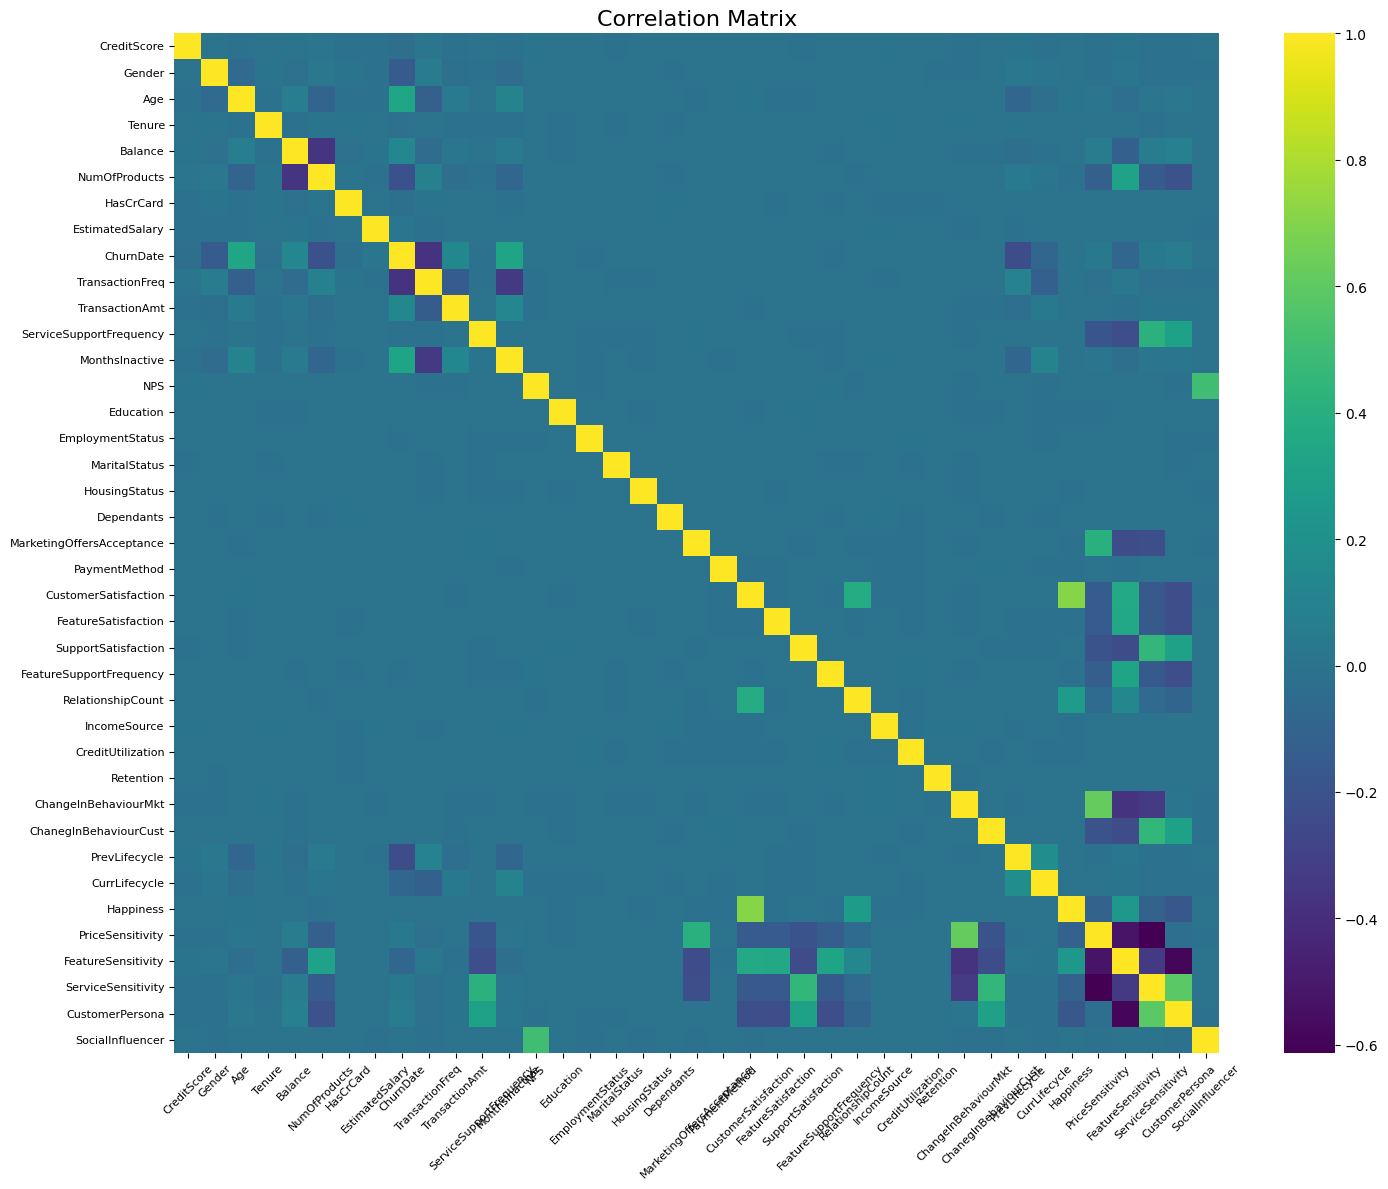

In [45]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming bank_df_train is your DataFrame with both numeric and categorical columns

# Create a copy of the DataFrame
encoded_df = bank_df_train.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns using LabelEncoder
for col in encoded_df.select_dtypes(include=['object']):
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

# Calculate correlation matrix
corr_matrix = encoded_df.corr()

# Plot the heatmap for all columns without numeric annotations
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')

# Customize the plot
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Display the plot
plt.tight_layout()
plt.show()

# Identify highly correlated columns
correlated_columns = []
threshold = 0.75   # Adjust as needed

for col in corr_matrix.columns:
    correlated_cols = corr_matrix.index[(corr_matrix[col] > threshold) | (corr_matrix[col] < -threshold)].tolist()
    correlated_cols.remove(col)  # Remove the current column itself
    correlated_columns.extend([(col, corr) for corr in correlated_cols])

# Print highly correlated columns and their correlations
for col, corr in correlated_columns:
    print(f"{col} and {corr}: {corr_matrix.loc[col, corr]}")

In [46]:
# useless_cols = ['Gender_Female']
# bank_df_train.drop(columns=useless_cols, inplace=True)

### 2. LDA

In [47]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Assuming bank_df_train is already defined and contains your data

# # Create a copy of bank_df_train
# test_df = bank_df_train.copy()

# # Separate features and target
# y = test_df['Exited']
# X = test_df.drop(columns=['Exited'])  # Drop 'Exited' column and create X

# # Convert X and y to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Reshape y to a 1D array if needed
# if y.ndim > 1:
#     y = y.ravel()

# # Initialize LDA model
# lda = LinearDiscriminantAnalysis(n_components=1)  # Set the number of components (dimensions)

# # Fit the model to the data
# lda.fit(X, y)

# # Transform the data
# X_lda = lda.transform(X)

# # Add the transformed data to the DataFrame
# test_df['LDA_Component'] = X_lda

# # Print the DataFrame with LDA component
# print(test_df)


### 3. PCA

Explained Variance Ratio: [0.0824385  0.06839166 0.04842035 0.04322022 0.04060072 0.03371231
 0.02761536 0.02746106 0.02743143 0.02737984 0.0273184  0.0272333
 0.02715451 0.02709305 0.02708891 0.02700048 0.02696375 0.02688697
 0.02683056 0.02680624]


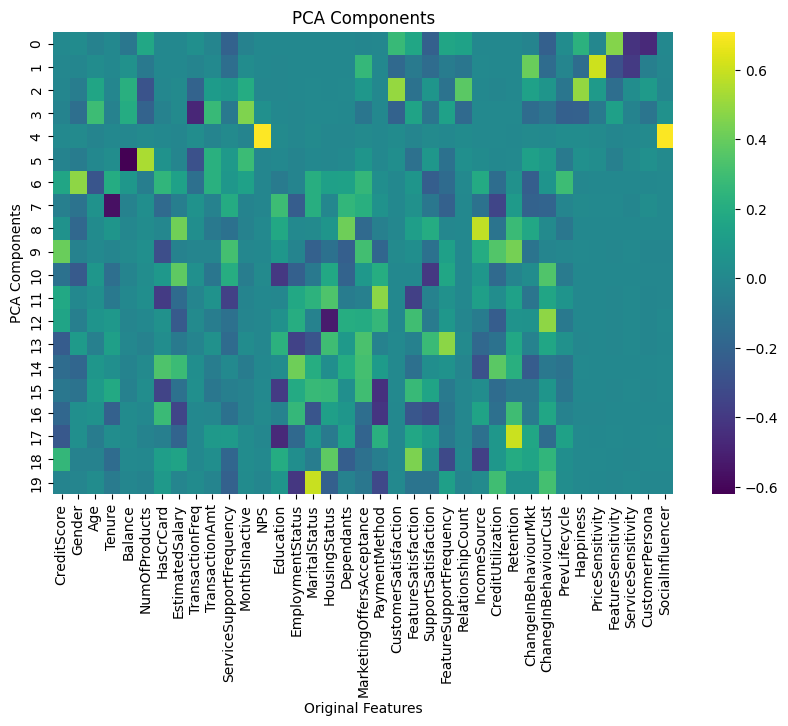

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Assuming bank_df_train is your DataFrame
df = bank_df_train.copy()

# Encode categorical columns
label_encoder = LabelEncoder()
for col in ['Gender', 'Education', 'EmploymentStatus', 'MaritalStatus', 'HousingStatus', 'PaymentMethod', 'IncomeSource', 'PrevLifecycle', 'CurrLifecycle', 'CustomerPersona']:
    df[col] = label_encoder.fit_transform(df[col])

# Drop target and date columns if applicable
X = df.drop(columns=['CurrLifecycle', 'ChurnDate'])  

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
n_components = 20  # Adjust as needed
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Create a DataFrame for PCA components
components_df = pd.DataFrame(pca.components_, columns=X.columns)

# Plot heatmap for PCA components
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, cmap='viridis', annot=False)
plt.title('PCA Components')
plt.xlabel('Original Features')
plt.ylabel('PCA Components')
plt.show()


### 4. Domain knowledge

In [66]:
#domain knowledge....

### 5. Try MCA 

In [71]:
col_idx = [(i, column_name) for i, column_name in enumerate(bank_df_train.columns)]

In [87]:
X_train_1 = bank_df_train.iloc[:, [1] + list(range(14, 17)) + [20, 26]]
X_train_2 = bank_df_train.iloc[:, 21:38]

In [88]:
mca = prince.MCA(n_components=2)
mca = mca.fit(X_train_1)

In [91]:
mca.column_contributions_.head().style.format('{:.0%}')

,0,1
Gender_Female,1%,1%
Gender_Male,1%,1%
Education_College,1%,1%
Education_Doctorate,1%,0%
Education_Graduate,0%,0%


### 6. FAMD

In [97]:
famd = prince.FAMD(n_components=2)
famd = famd.fit(X_train_2)

MemoryError: Unable to allocate 1.26 MiB for an array with shape (165034,) and data type float64

# Model training test
check if the data is fit for training

In [ ]:
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

# df = bank_df_train.copy()
# # df['ChurnDate_Numeric'].fillna(0, inplace=True)

# X = df.drop(columns=['Exited', 'ChurnDate'])
# y = df['Exited']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define XGBoost model
# model = XGBClassifier()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Evaluate model performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

#export to csv

In [ ]:
bank_df_train.to_csv('./data/final/train_data.csv', index=False)
bank_df_test.to_csv('./data/final/test_data.csv', index=False)
